In [1]:
from deepCNN import deepCNN
from utils import *
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
  device = torch.device('cuda')
elif torch.backends.mps.is_available():
  device = torch.device('mps')
else:
  device = torch.device('cpu')

print("Using", device)

Using cuda


In [3]:
model = deepCNN().to(device)
print(model)

deepCNN(
  (ConvLayer1): Sequential(
    (0): Conv2d(22, 32, kernel_size=(15, 1), stride=(1, 1), padding=(7, 0))
    (1): ELU(alpha=0.9, inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(15, 1), stride=(1, 1), padding=(7, 0))
    (4): ELU(alpha=0.9, inplace=True)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=(1, 0), dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.4, inplace=False)
  )
  (ConvLayer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(15, 1), stride=(1, 1), padding=(7, 0))
    (1): ELU(alpha=0.9, inplace=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=(1, 0), dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.4, inplace=False)
  )
  (ConvLayer3): Sequential(
    (0): C

In [4]:
X_train, y_train, X_test, y_test = init_data(subject=None)
X_train, y_train, X_test, y_test = preprocess_data(X_train, y_train, X_test, y_test, verbose=True)
train_loader, val_loader, test_loader = load_data(X_train, y_train, X_test, y_test, verbose=True)

print(train_loader)

Training data shape: (8460, 22, 250) Training target shape: (8460,)
Testing data shape: (443, 22, 250) Testing target shape: (443,)


In [5]:
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, eps=1e-8, weight_decay=0.01)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

In [6]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
num_epochs = 100

for epoch_idx in range(num_epochs):
    model.train() 
    train_count = 0
    train_correct_count = 0
    train_loss_accum = 0.0 
    for batch_idx, (train_x, train_y) in enumerate(train_loader):
        train_x = train_x.float().to(device)
        train_y = train_y.long().to(device)
        optimizer.zero_grad()
        logits = model(train_x)
        train_loss = criterion(logits, train_y)
        train_loss.backward()
        optimizer.step()
        train_loss_accum += train_loss.item() * train_x.size(0)
        
        with torch.no_grad():
            y_hat = torch.argmax(logits, dim=-1)
            train_correct_count += torch.sum(y_hat == train_y, axis=-1)
            train_count += train_x.size(0)
            
    train_acc = train_correct_count / train_count
    avg_train_loss = train_loss_accum / train_count
    
    model.eval()
    val_count = 0
    val_correct_count = 0
    val_loss_accum = 0.0
    with torch.no_grad():
        for idx, (val_x, val_y) in enumerate(val_loader):
            val_x = val_x.float().to(device)
            val_y = val_y.long().to(device)
            logits = model(val_x).detach()
            val_loss = criterion(logits, val_y) 
            val_loss_accum += val_loss.item() * val_x.size(0)
            
            y_hat = torch.argmax(logits, dim=-1)
            val_correct_count += torch.sum(y_hat == val_y, axis=-1)
            val_count += val_x.size(0)
            
    val_acc = val_correct_count / val_count
    avg_val_loss = val_loss_accum / val_count

    # scheduler.step()
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc.detach().cpu().item())
    val_accuracies.append(val_acc.detach().cpu().item())
    
    print('>>>Epoch: {:d}   Train Loss: {:.3f}, Train Acc: {:.3f}, Val Loss: {:.3f}, Val Acc: {:.3f}'.format(
        epoch_idx+1, avg_train_loss, train_acc, avg_val_loss, val_acc))

>>>Epoch: 1   Train Loss: 1.279, Train Acc: 0.438, Val Loss: 1.246, Val Acc: 0.498
>>>Epoch: 2   Train Loss: 1.231, Train Acc: 0.506, Val Loss: 1.225, Val Acc: 0.508
>>>Epoch: 3   Train Loss: 1.213, Train Acc: 0.532, Val Loss: 1.201, Val Acc: 0.541
>>>Epoch: 4   Train Loss: 1.214, Train Acc: 0.531, Val Loss: 1.197, Val Acc: 0.560
>>>Epoch: 5   Train Loss: 1.213, Train Acc: 0.534, Val Loss: 1.202, Val Acc: 0.546
>>>Epoch: 6   Train Loss: 1.209, Train Acc: 0.555, Val Loss: 1.204, Val Acc: 0.568
>>>Epoch: 7   Train Loss: 1.210, Train Acc: 0.550, Val Loss: 1.205, Val Acc: 0.556
>>>Epoch: 8   Train Loss: 1.210, Train Acc: 0.561, Val Loss: 1.192, Val Acc: 0.589
>>>Epoch: 9   Train Loss: 1.207, Train Acc: 0.559, Val Loss: 1.190, Val Acc: 0.570
>>>Epoch: 10   Train Loss: 1.209, Train Acc: 0.559, Val Loss: 1.202, Val Acc: 0.575
>>>Epoch: 11   Train Loss: 1.198, Train Acc: 0.570, Val Loss: 1.188, Val Acc: 0.567
>>>Epoch: 12   Train Loss: 1.193, Train Acc: 0.575, Val Loss: 1.203, Val Acc: 0.568
>

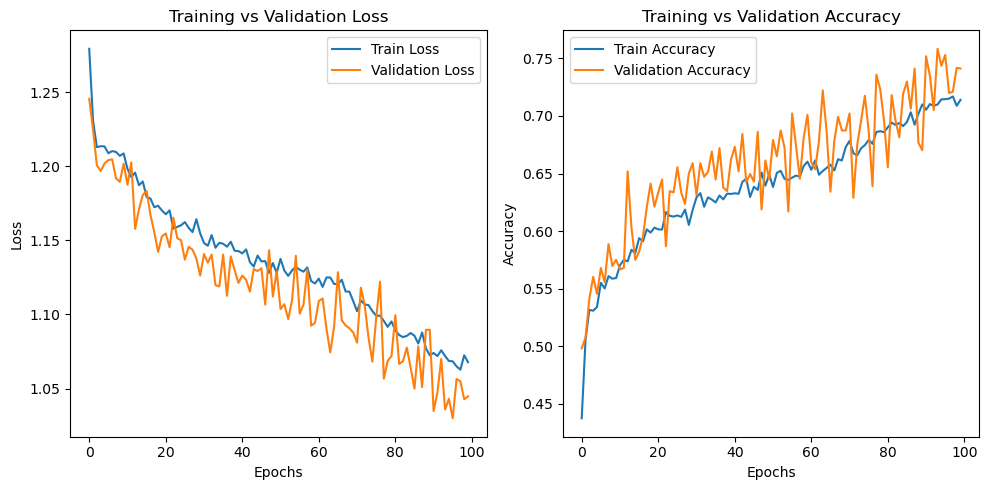

In [7]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the test set: {100 * correct / total}%')

Accuracy of the model on the test set: 65.23702031602708%


In [10]:
import pandas as pd

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, Conv2D,LSTM, BatchNormalization, MaxPooling1D, MaxPooling2D, AveragePooling2D, AveragePooling1D, Reshape
from keras.utils import np_utils
# from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from scipy import signal
from keras.regularizers import l2
import matplotlib.pyplot as plt

X_train, y_train, X_test, y_test = init_data(subject=None)
X_train, y_train, X_test, y_test = preprocess_data(X_train, y_train, X_test, y_test, verbose=True)

ind_valid = np.random.choice(8460, 1500, replace=False)
ind_train = np.array(list(set(range(8460)).difference(set(ind_valid))))
(x_train, x_valid) = X_train[ind_train], X_train[ind_valid] 
(y_train, y_valid) = y_train[ind_train], y_train[ind_valid]

y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)

x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)

x_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
y_test = to_categorical(y_test, 4)


dropout = 0.5
learning_rate = 0.001
epochs = 70
weight_decay = 1e-2

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(15,1), padding='same', activation='elu', input_shape=(250,1,22)))
model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Conv2D(filters=64, kernel_size=(15,1), padding='same', activation='elu'))
model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Conv2D(filters=128, kernel_size=(15,1), padding='same', activation='elu'))
model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Conv2D(filters=256, kernel_size=(15,1), padding='same', activation='elu'))
model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Flatten())
model.add(Dense(16, activation='elu', kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay)))
model.add(Dense(4, activation='softmax', kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay)))

optimizer = keras.optimizers.Adam(lr=learning_rate)

model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

model.summary()

results = model.fit(x_train,
            y_train,
            batch_size=64,
            epochs=epochs,
            validation_data=(x_valid, y_valid), verbose=1)

## Testing

score = model.evaluate(x_test, y_test, verbose=0)
print(f'Test accuracy:{score[1]}')

Training data shape: (8460, 22, 250) Training target shape: (8460,)
Testing data shape: (443, 22, 250) Testing target shape: (443,)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 250, 1, 32)        10592     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 84, 1, 32)        0         
 2D)                                                             
                                                                 
 batch_normalization_1 (Batc  (None, 84, 1, 32)        128       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 84, 1, 32)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 84, 1, 64)        

C:\Users\18646\anaconda3\envs\ece247\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/70
109/109 [==============================] - 8s 60ms/step - loss: 1.8107 - accuracy: 0.3454 - val_loss: 1.5175 - val_accuracy: 0.4360
Epoch 2/70
109/109 [==============================] - 6s 51ms/step - loss: 1.4924 - accuracy: 0.4435 - val_loss: 1.3654 - val_accuracy: 0.4967
Epoch 3/70
109/109 [==============================] - 6s 54ms/step - loss: 1.3515 - accuracy: 0.4909 - val_loss: 1.2783 - val_accuracy: 0.5173
Epoch 4/70
109/109 [==============================] - 6s 52ms/step - loss: 1.2307 - accuracy: 0.5421 - val_loss: 1.1450 - val_accuracy: 0.5893
Epoch 5/70
109/109 [==============================] - 6s 52ms/step - loss: 1.1328 - accuracy: 0.5782 - val_loss: 1.0723 - val_accuracy: 0.6107
Epoch 6/70
109/109 [==============================] - 6s 53ms/step - loss: 1.0457 - accuracy: 0.6191 - val_loss: 0.9160 - val_accuracy: 0.6967
Epoch 7/70
109/109 [==============================] - 6s 53ms/step - loss: 0.9517 - accuracy: 0.6546 - val_loss: 0.8441 - val_accuracy: 0.7073